In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from prob_rob.motion_models import OdometryMotionModel
from prob_rob.data import read_simple_world, read_simple_data
from prob_rob.utils import normalize_angle, sample_normal_distribution
from prob_rob.robot import BaseRobot
from prob_rob.map import LandmarkMap
from prob_rob.ekf_localization import EKFLocalizationKnown

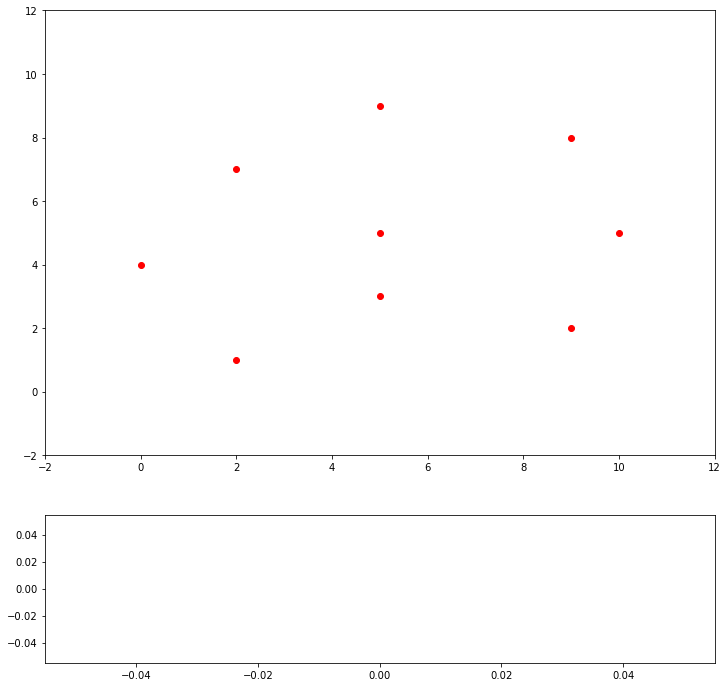

In [3]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_simple_data('./data/simple/sensor_data.dat')
landmarks = read_simple_world('./data/simple/world.dat')

landmark_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

EKF = EKFLocalizationKnown(robot.pose, motion_model)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
cov_dets = []

fig, (ax, ax1) = plt.subplots(2, 1, 
                              figsize=(12, 12), 
                              gridspec_kw={'height_ratios':[3, 1]})
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'g', zorder=2)
pn, = ax.plot([], [], 'bx', markersize=5, zorder=1)
sline, = ax.plot([], [], 'k')
det_line, = ax1.plot([], [])

for key, value in landmark_map.landmarks.items():
    ax.plot(value[0], value[1], 'ro', zorder=0)
    
def init():
    ln.set_data([], [])
    sline.set_data([], [])
    det_line.set_data([], [])
    return ln, pn, sline, det_line,

def update(frame):
    command, readings = frame
    
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    
    rx = EKF._mean.item(0)
    ry = EKF._mean.item(1)
    rtheta = normalize_angle(EKF._mean.item(2))
    
    line_x = []
    line_y = []
    
    for reading in readings:
        lid, srange, sbearing = reading
        
        ang = normalize_angle(sbearing + rtheta)
        olx = rx + srange * math.cos(ang)
        oly = ry + srange * math.sin(ang)
        
        line_x.append([rx, olx])
        line_y.append([ry, oly])
    
    EKF.correct(readings, landmark_map)
    
    EKF_x.append(EKF.mean.item(0))
    EKF_y.append(EKF.mean.item(1))
    
    cov_det = np.linalg.det(EKF.cov)
    cov_dets.append(cov_det)
    
    ln.set_data(x, y)
    pn.set_data(EKF_x, EKF_y)
    sline.set_data(line_x, line_y)
    
    cr = range(0, len(cov_dets))
    det_line.set_data(cr, cov_dets)
    ax1.set_xlim((0, len(cov_dets)))
    ax1.set_ylim((0, max(cov_dets)*1.1))
    
    return ln, pn, sline, det_line,

ani = FuncAnimation(fig, update, frames=zip(commands, sensor), init_func=init, blit=True, interval=66)

In [4]:
HTML(ani.to_html5_video())